# Importing Libraries..

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller

## Load Dataset

In [2]:
df=pd.read_csv("MonthWiseMarketArrivals_Clean.csv")

## Check Dataset

In [3]:
df.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
0,ABOHAR(PB),January,2005,2350,404,493,446,PB,ABOHAR,January-2005
1,ABOHAR(PB),January,2006,900,487,638,563,PB,ABOHAR,January-2006
2,ABOHAR(PB),January,2010,790,1283,1592,1460,PB,ABOHAR,January-2010
3,ABOHAR(PB),January,2011,245,3067,3750,3433,PB,ABOHAR,January-2011
4,ABOHAR(PB),January,2012,1035,523,686,605,PB,ABOHAR,January-2012


In [4]:
df.date=pd.DatetimeIndex(df.date)

## Get Mumbai Data

In [8]:
dfMumbai = df[df['city']=='MUMBAI']

## sort by month

In [16]:
dfMumbai = df[df.city == 'MUMBAI']
dfMumbai = dfMumbai.sort_values(by = "month")
dfMumbai.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
6702,MUMBAI,April,2014,238351,638,1238,939,MS,MUMBAI,2014-04-01
6703,MUMBAI,April,2015,243100,1209,1445,1327,MS,MUMBAI,2015-04-01
6692,MUMBAI,April,2004,198200,346,475,397,MS,MUMBAI,2004-04-01
6693,MUMBAI,April,2005,286150,238,419,328,MS,MUMBAI,2005-04-01
6694,MUMBAI,April,2006,253765,240,343,290,MS,MUMBAI,2006-04-01


### set precision

In [17]:
pd.set_option('precision', 0)

In [18]:
dfMumbai.describe()

,year,quantity,priceMin,priceMax,priceMod
count,146,146,146,146,146
mean,2010,221721,901,1317,1114
std,4,40793,731,1019,883
min,2004,131590,215,335,287
25%,2007,195125,434,648,544
50%,2010,222220,692,982,846
75%,2013,246050,1099,1623,1392
max,2016,413681,4005,5517,4714


In [19]:
dfMumbai.index = pd.PeriodIndex(dfMumbai.month, freq='M')

## Plot

<AxesSubplot:xlabel='month'>

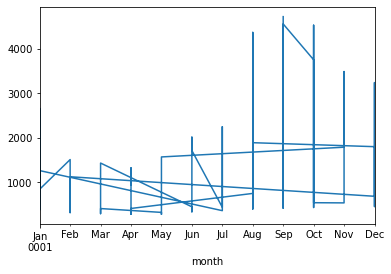

In [22]:
dfMumbai.priceMod.plot()

In [23]:
dfMumbai["diff"]=dfMumbai.priceMax-dfMumbai.priceMin
dfMumbai['monthVal'] = pd.DatetimeIndex(dfMumbai['date']).month

In [24]:
dfMumbaiPivot = pd.pivot_table(dfMumbai, values = "diff", columns = "year", index = "monthVal")

<AxesSubplot:xlabel='monthVal'>

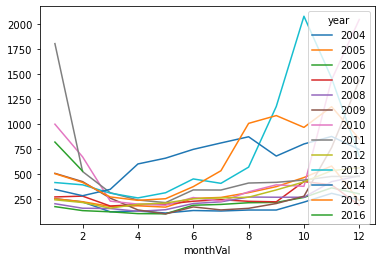

In [25]:
dfMumbaiPivot.plot()

<AxesSubplot:ylabel='Frequency'>

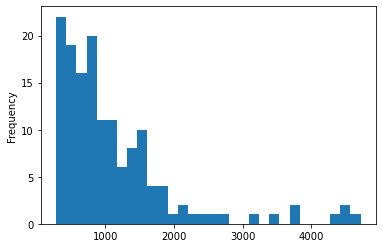

In [26]:
dfMumbai.priceMod.plot(kind = "hist", bins = 30)

In [27]:
dfMumbai['priceModLog'] = np.log(dfMumbai.priceMod)
dfMumbai.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date,diff,monthVal,priceModLog
month,,,,,,,,,,,,,
0001-04,MUMBAI,April,2014,238351,638,1238,939,MS,MUMBAI,2014-04-01,600,4,7
0001-04,MUMBAI,April,2015,243100,1209,1445,1327,MS,MUMBAI,2015-04-01,236,4,7
0001-04,MUMBAI,April,2004,198200,346,475,397,MS,MUMBAI,2004-04-01,129,4,6
0001-04,MUMBAI,April,2005,286150,238,419,328,MS,MUMBAI,2005-04-01,181,4,6
0001-04,MUMBAI,April,2006,253765,240,343,290,MS,MUMBAI,2006-04-01,103,4,6


<AxesSubplot:ylabel='Frequency'>

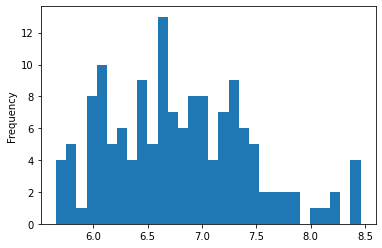

In [28]:
dfMumbai.priceModLog.plot(kind = "hist", bins = 30)

In [29]:
model_mean_pred = dfMumbai.priceModLog.mean()
dfMumbai["priceMean"] = np.exp(model_mean_pred)

<AxesSubplot:xlabel='date'>

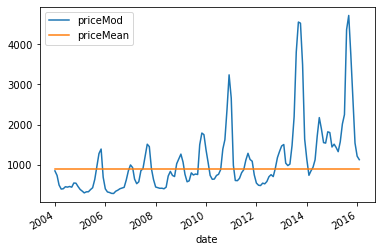

In [30]:
dfMumbai.plot(kind="line", x="date", y = ["priceMod", "priceMean"])

# RMSE

In [31]:
def RMSE(predicted, actual):
    mse = (predicted - actual)**2
    rmse = np.sqrt(mse.sum()/mse.count())
    return rmse

In [32]:
model_mean_RMSE = RMSE(dfMumbai.priceMean, dfMumbai.priceMod)
model_mean_RMSE

908.4772843986443

In [33]:
dfMumbaiResults = pd.DataFrame(columns = ["Model", "Forecast", "RMSE"])
dfMumbaiResults.loc[0,"Model"] = "Mean"
dfMumbaiResults.loc[0,"Forecast"] = np.exp(model_mean_pred)
dfMumbaiResults.loc[0,"RMSE"] = model_mean_RMSE
dfMumbaiResults.head()

,Model,Forecast,RMSE
0,Mean,889,908


In [34]:
dfMumbai["timeIndex"] = dfMumbai.date - dfMumbai.date.min()
dfMumbai["timeIndex"] =  dfMumbai["timeIndex"]/np.timedelta64(1, 'M')
dfMumbai["timeIndex"] = dfMumbai["timeIndex"].round(0).astype(int)

In [35]:
model_linear = smf.ols('priceModLog ~ timeIndex', data = dfMumbai).fit()

In [36]:
model_linear.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            priceModLog   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     129.3
Date:                Sat, 21 May 2022   Prob (F-statistic):           8.89e-22
Time:                        21:49:53   Log-Likelihood:                -96.121
No. Observations:                 146   AIC:                             196.2
Df Residuals:                     144   BIC:                             202.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.0284      0.078     77.785      0.000       5.875       6.182
timeIndex      0.0105      0.001     11.370      0.000       0.009       0.012
==============================================================================
Omnibus:                        7.658   Durbin-Watson:                   1.551
Prob(Omnibus):                  0.022   Jarque-Bera (JB):                8.054
Skew:                           0.566   Prob(JB):                       0.0178
Kurtosis:                       2.791   Cond. No.                         167.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
# model_linear.params
model_linear_pred = model_linear.predict()

In [38]:
model_linear_pred

array([7.32084247, 7.44693336, 6.05993359, 6.18602448, 6.31211537,
       6.43820626, 7.19475158, 6.69038803, 6.81647892, 6.94256981,
       7.06866069, 6.56429714, 7.11069099, 6.9846001 , 6.85850921,
       6.73241833, 6.60632744, 6.22805478, 6.35414566, 6.10196389,
       7.23678188, 7.48896365, 6.48023655, 7.36287277, 7.40490306,
       7.53099395, 6.14399418, 7.27881217, 7.15272129, 7.0266304 ,
       6.90053951, 6.77444862, 6.64835774, 6.52226685, 6.39617596,
       6.27008507, 7.5520091 , 7.29982732, 6.16500933, 6.29110022,
       6.41719111, 6.543282  , 6.66937288, 6.79546377, 6.92155466,
       7.04764555, 7.17373643, 6.03891844, 7.42591821, 6.02841087,
       7.41541064, 7.28931975, 7.16322886, 7.03713797, 6.91104708,
       6.7849562 , 7.54150152, 6.53277442, 6.40668353, 6.28059265,
       6.15450176, 6.65886531, 6.34363809, 6.46972898, 6.59581987,
       6.72191075, 6.84800164, 7.10018342, 7.2262743 , 7.35236519,
       7.47845608, 6.2175472 , 6.97409253, 6.09145631, 7.34185

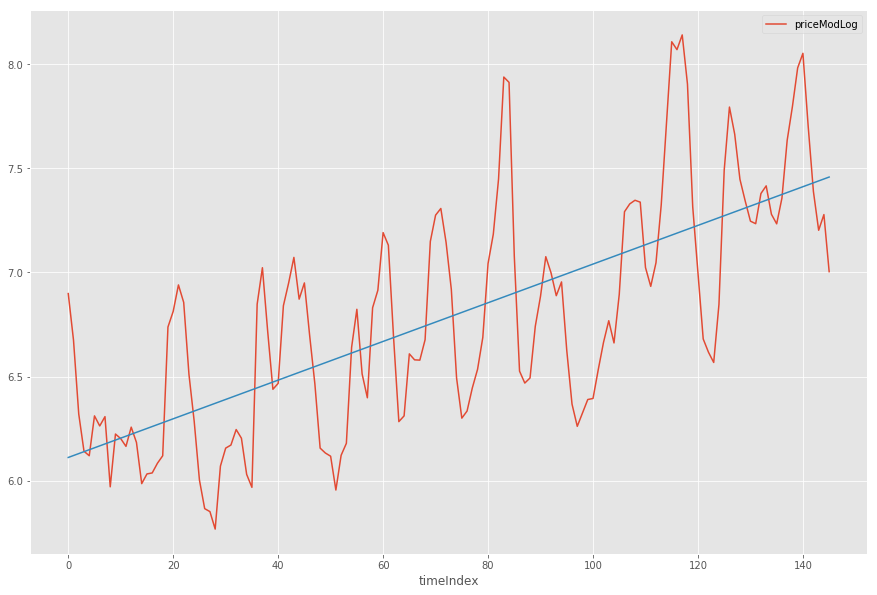

In [46]:
dfMumbai.plot(kind="line", x="timeIndex", y = "priceModLog")
plt.plot(dfMumbai.timeIndex,model_linear_pred, '-')

In [39]:
dfMumbai["priceLinear"] = np.exp(model_linear_pred)

In [40]:
model_linear_RMSE = RMSE(dfMumbai.priceLinear, dfMumbai.priceMod)
model_linear_RMSE

724.7073314178774

<AxesSubplot:xlabel='timeIndex'>

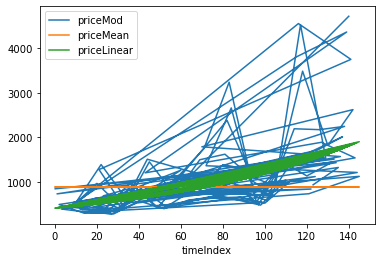

In [41]:
dfMumbai.plot(kind="line", x="timeIndex", y = ["priceMod", "priceMean", "priceLinear"])